# Chainerで多層パーセプトロンを作ろう
## MNISTデータで手書き文字認識

- このファイルは以下のGitHubディレクトリにあるtrain_mnist.pyをipython notebookにペタペタ貼ったものです。
https://github.com/pfnet/chainer/tree/master/examples/mnist
- [Chainer@GitHub](https://github.com/pfnet/chainer.git)をクローンしてきて、chainer/examples/mnist/の中においても使えます。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from chainer import Variable, Chain, optimizers
import chainer.functions as F
import chainer.links as L

## データの読み込み

In [4]:
import data

In [5]:
mnist = data.load_mnist_data()

In [6]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)}

In [7]:
mnist['data'].max()

255

In [8]:
x_all = mnist['data'].astype(np.float32) / 255
y_all = mnist['target'].astype(np.int32)

In [9]:
x_train, x_test = np.split(x_all, [60000])
y_train, y_test = np.split(y_all, [60000])

[5 0 4 1 9 2 1 3 1 4]


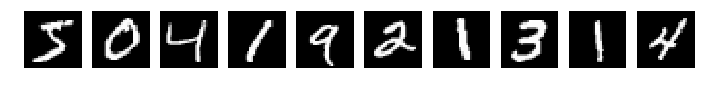

In [10]:
n_fig = 10
fig, ax = plt.subplots(1, n_fig, figsize=(12, 6))

for i in xrange(n_fig):
    ax[i].imshow(x_all[i, :].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax[i].axis('off')

print(y_all[:n_fig])

## モデルを定義

In [11]:
class MLP(Chain):
    def __init__(self):
        super(MLP, self).__init__(
            l1 = L.Linear(784, 100),
            l2 = L.Linear(100, 100),
            l3 = L.Linear(100, 10),
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

損失関数と分類精度の計算をするために、MLP chainの上にclassifier chainを作る。

In [12]:
class MyClassifier(Chain):
    """
    Compute accuracy and loss.
    
    Returns:
        loss
    """
    
    def __init__(self, predictor):
        super(MyClassifier, self).__init__(
            predictor=predictor
        )
    
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

今、定義したMyClassifierクラスと似たクラスが、chainer.links.Classifierに定義されているので、通常はそっちをつかうべし。

In [13]:
model = MyClassifier(MLP())
#model = L.Classifier(MLP())    # <- 本来ならこっちの方が良い

In [14]:
optimizer = optimizers.SGD()

In [15]:
optimizer.setup(model)

### 書き方１

In [16]:
batchsize = 100
datasize = 60000

In [17]:
for epoch in range(20):
    print('epoch %d' % epoch)
    indices = np.random.permutation(datasize)
    for i in range(0, datasize, batchsize):
        x = Variable(x_train[indices[i : i + batchsize]])
        t = Variable(y_train[indices[i : i + batchsize]])
        
        optimizer.update(model, x, t)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19


### 書き方２

In [18]:
# モデルを初期化
model = MyClassifier(MLP())
optimizer = optimizers.SGD()
optimizer.setup(model)

In [19]:
batchsize = 100
datasize = 60000

In [20]:
for epoch in range(20):
    print('epoch %d' % epoch)
    
    # Compute test/validation error
    sum_loss, sum_accuracy = 0, 0
    for i in range(0, 10000, batchsize):
        x = Variable(x_test[i : i + batchsize])
        t = Variable(y_test[i : i + batchsize])
        loss = model(x, t)
        sum_loss += loss.data * batchsize
        sum_accuracy += model.accuracy.data * batchsize

    mean_loss = sum_loss / 10000
    mean_accuracy = sum_accuracy / 10000

    print("mean loss: %.5f\t mean accuracy: %.5f" % (mean_loss, mean_accuracy))    
    
    indices = np.random.permutation(datasize)
    for i in range(0, datasize, batchsize):
        x = Variable(x_train[indices[i : i + batchsize]])
        t = Variable(y_train[indices[i : i + batchsize]])
        
        model.zerograds()
        loss = model(x, t)
        loss.backward()
                
        optimizer.update()

epoch 0
mean loss: 2.30623	 mean accuracy: 0.07260
epoch 1
mean loss: 0.60796	 mean accuracy: 0.85770
epoch 2
mean loss: 0.39127	 mean accuracy: 0.89320
epoch 3
mean loss: 0.33631	 mean accuracy: 0.90290
epoch 4
mean loss: 0.30919	 mean accuracy: 0.91140
epoch 5
mean loss: 0.28786	 mean accuracy: 0.91630
epoch 6
mean loss: 0.27477	 mean accuracy: 0.91990
epoch 7
mean loss: 0.26252	 mean accuracy: 0.92330
epoch 8
mean loss: 0.25170	 mean accuracy: 0.92700
epoch 9
mean loss: 0.24060	 mean accuracy: 0.93030
epoch 10
mean loss: 0.23181	 mean accuracy: 0.93290
epoch 11
mean loss: 0.22355	 mean accuracy: 0.93540
epoch 12
mean loss: 0.21520	 mean accuracy: 0.93650
epoch 13
mean loss: 0.20779	 mean accuracy: 0.93960
epoch 14
mean loss: 0.20010	 mean accuracy: 0.94170
epoch 15
mean loss: 0.19349	 mean accuracy: 0.94370
epoch 16
mean loss: 0.18660	 mean accuracy: 0.94590
epoch 17
mean loss: 0.18305	 mean accuracy: 0.94720
epoch 18
mean loss: 0.17665	 mean accuracy: 0.94870
epoch 19
mean loss: 0.